# 15 minutes to QCoDeS

This short introduction is aimed mainly for beginner's. Before you can start with your first code using QCoDeS make sure you have properly set up the environment for QCoDeS (look at [this  documentation](http://qcodes.github.io/Qcodes/start/index.html#installation)). 

## Introduction 

An experimental setup comprises of many instruments. We call an experimental setup as "station". A station is connected to many instruments or devices. QcoDeS provides a way to interact with all these instruments to help users perform the measurements and store the data in a database. To interact (read/ write/ trigger etc) with individual instruments we have created a [library of drivers](http://qcodes.github.io/Qcodes/api/generated/qcodes.instrument_drivers.html) for commonly used instruments. These drivers implement the commonly needed functionalities of the instruments. 

An "Instrument" can perform many functions. For example, on an oscilloscope instrument, we first set a correct trigger level and other parameters and then obtain a trace. In QCoDeS lingo, we call "trigger_level" and "trace" as `parameters` of this `instrument`. An instrument at any moment will have many such parameters which together defines the state of the instrument, hence a parameter can be thought of as a state variable of the instrument. QCoDeS provides a method to set values of this parameter (set trigger level) and get the values from them (obtain a trace). This way we can interact with all the needed parameters of an instrument and are ready to set up a measurement. 

QCoDeS also have a similar programmatic structure as explained above. QCoDeS structure comprises of a `Station` class which is a bucket of objects from `Instrument` class containing many `Parameters`. The value of these parameters is set and measured during a measurement. The `Measurement` class provides a context manager for registering the parameters and providing a link between different parameters. The measured data is stored in a database.

Here, we will briefly discuss how you can set up your experiment with the help of Qcodes. 


## Imports

Customarily we import as follows:

In [2]:
%matplotlib inline
import os
import numpy.random as rd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station, load_or_create_experiment, \
    initialise_database, Measurement, load_by_run_spec, load_by_guid
from qcodes import load_last_experiment, load_experiment, new_experiment, experiments
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging




## Logging 

In [3]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\a-halakh\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Every session must have logging turned on. This not only allows users to have all the logs in case troubleshooting is required but is also crucial to flush all the logging information to the Azure cloud platform(only if you have turned telemetry on in your qcodes configuration). You can find the log files at the location of the 'Filename' shown above.

## Station creation  

A station is a collection of all the instruments and devices present in your experiment. As mentioned earlier, it can be thought of as a bucket where you can add your `instruments`, `parameters` and other `components`. Each of these terms has a definite meaning in QCoDeS and is explained in later sections. Once a station is properly configured you can use its instance to access these components. Refer to tutorial on [Station](http://qcodes.github.io/Qcodes/examples/Station.html) for more details.

we start with instantiating instrument class which at the moment does not comprise of any instrument or paramater.

In [4]:
station = qc.Station()

We can look at all the instruments and the parameters inside this station bucket using `snapshot` method. Since at the moment we have not added anything to our station our snapshot will contain nothing. 

### Snapshot

In [5]:
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'default_measurement': []}

The [snapshot](http://qcodes.github.io/Qcodes/examples/DataSet/Working%20with%20snapshots.html) of the station is categorized as the dictionary of all the `instruments`,` parameters`, `components` and list of `default_measurement`. Once you have populated your station you may want to look at the snapshot again.

## Instrument

Instruments class in Qcodes is responsible for holding connections to hardware, creating a parameter, function, or method for each piece of functionality of the inestrument. For more information on instrument class you can look at the [detailed description here](http://qcodes.github.io/Qcodes/user/intro.html#instrument)  or in the [api documentation](http://qcodes.github.io/Qcodes/api/instrument/index.html) regarding instruments. 

In [6]:
# A dummy instrument dac with two parameters ch1 and Ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy instrument dmm with two parameters ch1 and Ch2
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

### Add instruments into station 

Every instrument that you are working with in an experiment should be add to the instacne of the `Station`. Here, we add the dac and dmm instruments. 

In [7]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

### Simulating the response of instrument 

You may **ignore this block** during the first read. In actual experiments you will not need to simulate the response

In [8]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal
def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()
        

# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val

dmm.v1.get = partial(customgetter, dac)

## Parameter

Qcodes `Parameter` has the property that it is settable, gettable or both. Let us understand this with an example of a real instrument say oscilloscope. An oscilloscope contains a lot of settings such as trigger mode, trigger level, source etc. Most of these settings can be set to a particular value in the instrument say trigger mode can be set to 'edge' mode, trigger level to some floating number etc, hence these parameters are settable. Similarly, for many parameters, you may also be able to retrieve values hence they are gettable. In this example notebook, we have 'dac' instrument with 'ch1' and 'ch2' as `Parameter`s. Similarly, we have dmm instrument with 'v1' and 'v1' as `Parameters`. Apart from this obvious use of `Parameter` as the standard parameter of the instrument it may also be used as variable, i.e. storing/retrieving a value, or be subclassed for more complex uses.

In [9]:
dac.ch1(1.1)

and get the ouput voltage of dmm as

In [10]:
dmm.v1()

3.9842490567480477

Further information can be found in the [user guide](http://qcodes.github.io/Qcodes/user/intro.html#parameter) or [api documentation](http://qcodes.github.io/Qcodes/api/parameters/index.html) of parameter. 

## Initialise database and experiment

Before starting a measurement we first initialise a database in the location specified by the config object (read the config section below). The db is created with the latest supported version. If the database already exists then that database is used but is upgraded to the latest version.

In [11]:
initialise_database()

### Current location of database

In [12]:
qc.config.core.db_location

'~/experiments.db'

### Change location of database

To change the location of the data base to the current working directory.

In [13]:
cwd = os.getcwd()
qc.config["core"]["db_location"] = os.path.join(cwd, 'testing.db')

### Load or create experiment

After initialising the database we create the `Experiment` object. This object contains the name of the experiment and the sample, and the path of the database. You can  use `load_or_create_experiment` to find and return an experiment with the given experiment and sample name if it already exists, or create one if not found.

In [14]:
exp = load_or_create_experiment(experiment_name='dataset_context_manager',
                                sample_name="no sample1")

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.68it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.01it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v7 -> v8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.00it/s]


The methods shown above to load or create the experiment is the most versatile one. However for specifics cases other methods (listed below) to create or load experiments may also be used.

In [15]:
# load_experiment_by_name(experiment_name='dataset_context_manager',sample_name="no sample")
# load_last_experiment()
# load_experiment(1)
# new_experiment(experiment_name='dataset_context_manager',sample_name="no sample")

## Measurement

Qcodes `Measurement` module provides a context manager for registering parameters to measure and store results. The measurement is first linked to the correct experiment and station by passing them as an argument. If no argument is given, the currently loaded experiment and station are taken as default. 

Qcodes is capable of storing relation between parameter i.e. which parameter is independent and which parameter depends on another one. This capability is later used to make useful plots, where the knowledge of interdependencies is used to infer what goes on x-axis and what on y-axis. All the parameters required in the measurement are first registered. In case a parameter depends on another parameter then another parameter is declared as a 'setpoint'. In Qcodes lingo 'setpoint' parameter means the parameter on which another parameter depends. In current example, dac.ch1 is the independent parameter and dmm.v1 is the dependent parameter whose setpoint is dac.ch1.

`meas.write_period` is used to define the periods after which the data is committed to the database. We do not commit individual datapoint during measurement to the database but only after some amount of data is collected in stipulated time period (in this case for 2 seconds). The default value of write_period is 5 seconds.   

The meas.run() returns a context manager for the experiment run. The `_enter_` method of the context manager returns the `DataSaver` object to the datasaver variable. The `DataSaver` class handles the saving of data to the database using the method add_result. The add_result methods validate the sizes of all the data points and store them intermittently into a private variable. Every write-period (meas.write_period) of the measurement the data of the private variable is flushed to the database.

In [16]:
meas = Measurement(exp=exp, station=station)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.write_period = 2 

with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 1


## Data exploration

### List all the experiments in the database 

You can list all the experiments in the database as following.

In [17]:
experiments()

[dataset_context_manager#no sample1#1@C:\Users\a-halakh\Documents\Microsoft\QcodesHarshit\docs\examples\testing.db
 -----------------------------------------------------------------------------------------------------------------
 1-results-1-dac_ch1,dmm_v1-10]

Currently the database contains only few  experiments but in a lab the database will contain several experiments containing many datasets. Seldom, you would like to load a dataset from a particular experiment for further analysis. Here we look at the ways to find and retrieve already measured dataset from the data base.

### List all the datasets in the database

You can look at the datasets in the current experiment using:

In [18]:
exp.data_sets()

[results #1@C:\Users\a-halakh\Documents\Microsoft\QcodesHarshit\docs\examples\testing.db
 ---------------------------------------------------------------------------------------
 dac_ch1 - numeric
 dmm_v1 - numeric]

### Load the data set using one or more specifications

`load_by_run_spec` can be used to load a run from one or more pieces of runs specification such as 'experiment name', 'sample name' etc. All fields are optional but the function will raise an error if more than one run matching the supplied specification is found. Along with the error specs of the runs found will be printed. Refer to the section 'Uniquely identifying and loading runs' in [this example notebook](http://qcodes.github.io/Qcodes/examples/DataSet/Extracting-runs-from-one-DB-file-to-another.html#Uniquely-identifying-and-loading-runs) 

In [19]:
dataset = load_by_run_spec(experiment_name='dataset_context_manager', captured_run_id=1)

### Plot dataset 

Now, you can plot this dataset using `plot_dataset`

([<matplotlib.axes._subplots.AxesSubplot at 0x1e926393748>], [None])

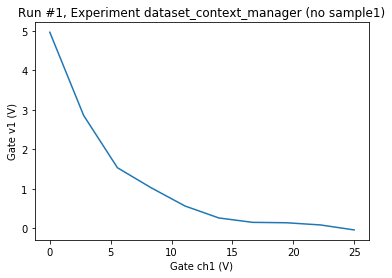

In [20]:
plot_dataset(dataset)

### Get data of specific parameter of a dataset

If you are interested in a particular parameter in a dataset you can get is using `get_parameter_data`

In [21]:
dataset.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [22]:
dataset.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([ 4.96513235,  2.85963703,  1.53375351,  1.02493821,  0.56443461,
          0.2617394 ,  0.15056644,  0.14064705,  0.08539503, -0.04076   ]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

Refer to exporting data section of the [example notebook](http://qcodes.github.io/Qcodes/examples/DataSet/Dataset%20Context%20Manager.html?highlight=get_parameter_data) to have more information on `get_parameter_data`

## Other important things

### QCoDeS Configuration  

QCoDeS uses a JSON based configuration system. It is shipped with a default configuration. The default config file should not be overwritten. If you have any modifications, you should save the updated config file on your home directory or in the current working directory of your script/notebook. The QCoDeS config system first looks in the current directory for a config file and then in the home directory for one and only then - if no config files are found - it falls back to using the default one. The default config is located in `qcodes.qcodes.config`. To know how to change and save the config please refer to the [documentation on config](http://qcodes.github.io/Qcodes/user/configuration.html?)

### Export data to pandas dataframe|

The data from the database can also be exported to the pandas dataframe.Also refer to the [example notebook on wroking with pandas](http://qcodes.github.io/Qcodes/examples/DataSet/Working-With-Pandas-and-XArray.html)

In [23]:
df = dataset.get_data_as_pandas_dataframe()['dmm_v1']
df.head()

,dmm_v1
dac_ch1,
0.000000,4.965132
2.777778,2.859637
5.555556,1.533754
8.333333,1.024938
11.111111,0.564435


### Writing drivers

We support and provide the drivers for most of the instruments currently in use at the Microsoft stations. However, if more functionalities than the ones which are currently supported by drivers are required, one may update the driver or request the features form Qcodes team. If you would like to have a quick overview on how to write the drivers refer to the [example notebooks on writing drivers](http://qcodes.github.io/Qcodes/examples/index.html#writing-drivers)

### Monitor